#Iniziamo Transfer Learning su Tensorflow
Si basa sul prendere un modello già trainato e modificarlo parzialmete per poi eseguire un training sui parametri modificati, il re-train può essere fatto a vari livelli, per ora lo impementiamo solo sull'output layer.

In [1]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-01-16 15:25:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.208, 142.250.73.208, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   211MB/s    in 0.8s    

2022-01-16 15:25:30 (211 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#Creiamo Callback Tensorboard
Per confromtare i modelli utilizzando *TensorBoard*

In [3]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [5]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

Funzione per caricare il modello già treinato e modificare solamente l'ultimo livello di output in base al numero di classi che vuoi

In [6]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [7]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [8]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220116-152540
Epoch 1/5
24/24 [==============================] - 29s 738ms/step - loss: 1.8116 - accuracy: 0.4040 - val_loss: 1.1370 - val_accuracy: 0.6420
Epoch 2/5
24/24 [==============================] - 15s 663ms/step - loss: 0.8488 - accuracy: 0.7627 - val_loss: 0.8422 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.5976 - accuracy: 0.8187 - val_loss: 0.7420 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.4589 - accuracy: 0.8920 - val_loss: 0.7019 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 15s 656ms/step - loss: 0.3575 - accuracy: 0.9267 - val_loss: 0.6631 - val_accuracy: 0.7808


In [9]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

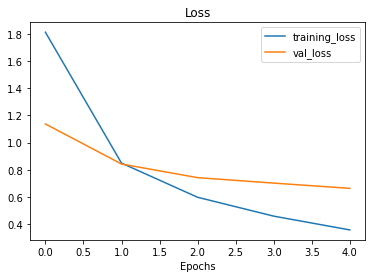

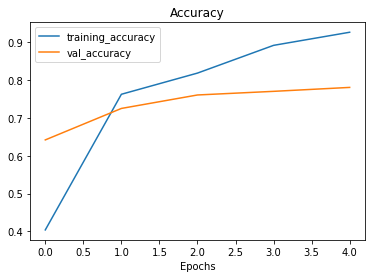

In [10]:
plot_loss_curves(resnet_history)

In [11]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220116-152727
Epoch 1/5
24/24 [==============================] - 25s 709ms/step - loss: 1.9184 - accuracy: 0.3880 - val_loss: 1.3415 - val_accuracy: 0.7332
Epoch 2/5
24/24 [==============================] - 15s 644ms/step - loss: 1.0795 - accuracy: 0.7613 - val_loss: 0.8778 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 15s 640ms/step - loss: 0.7652 - accuracy: 0.8453 - val_loss: 0.7011 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 15s 635ms/step - loss: 0.6100 - accuracy: 0.8720 - val_loss: 0.6130 - val_accuracy: 0.8504
Epoch 5/5
24/24 [==============================] - 15s 640ms/step - loss: 0.5155 - accuracy: 0.8960 - val_loss: 0.5590 - val_accuracy: 0.8560


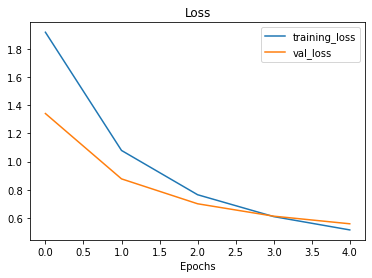

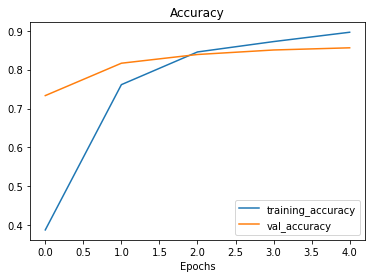

In [12]:
plot_loss_curves(efficientnet_history)